In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px


In [2]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api


In [3]:
import numpy as np
import pandas as pd
import plots
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from helper import Helper





In [4]:
""" Custome Extended Models imported from ../scripts folder """

from decisionTreesModel import DecisionTreesModel
from logesticRegressionModel import LogesticRegressionModel
from xGBClassifierModel import XGBClassifierModel


In [5]:
CSV_PATH = "../Data/data.csv"

In [6]:
helper = Helper()

In [7]:
df = helper.read_csv(CSV_PATH)
df.head()

file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [8]:
def get_data(tag, path='Data/clean_data.csv', repo='https://github.com/daniEL2371/abtest-mlops'):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [9]:

def drop_no_responds(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df




### Data Transformation

In [10]:
cleaned_df = drop_no_responds(df)
cleaned_df['aware'] = cleaned_df['yes'].map(lambda x: x==1)
cleaned_df = cleaned_df.drop(columns = ['yes', 'no', 'auction_id'], axis=1)

In [11]:
def save_cleaned_data():
    CLEANED_CSV_PATH = "../Data/clean_data.csv"
    helper.save_csv(cleaned_df, CLEANED_CSV_PATH)

### Data preparation

##### Label Encoding

In [12]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(cleaned_df['experiment'])
    df['browser'] = aware_encoder.fit_transform(df['browser'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])


    
    return df
    
    

#### Spliting the data based on browser and platform_os

In [13]:

def feature_data(cleaned_df):
    
    broweser_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'browser', 'aware']]
    platfrom_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'aware']]

    return broweser_df, platfrom_df


In [14]:

def save_encoded_df(encoded_df):
    
    broweser_df, platfrom_df = feature_data(encoded_df)
    helper.save_csv(broweser_df, "../Data/clean_data.csv")
    helper.save_csv(platfrom_df, "../Data/clean_data.csv")
    

In [15]:
"""Uncomment this if you want to save new version of cleaned dataframe"""

# encoded_df = encode_labels(cleaned_df)
# save_encoded_df(encoded_df)



'Uncomment this if you want to save new version of cleaned dataframe'

### Model Building

#### Loss function

In [16]:
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


#### Data to train and test Split function

In [17]:
def split_train_test(X, y, test_size=0.1):
    return train_test_split(X, y, test_size=test_size, random_state=42)
    
    

    

#### Decision Tree Model

### Get our two versions of encoded dataframes from dvc

In [ ]:
platform_df = get_data('enc-platform-df-v2')
browser_df = get_data('enc-browser-df-v2')


In [ ]:

print("1. Encoded Dataframe containing the the platfrom column")
platform_df.head()


In [ ]:

print("2. Encoded Dataframe containing the the browser column")
browser_df.head()


### 1 Model training using Decision Tree using browser dataframe

#### Train Test Split

In [21]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#### Model Training Using DecisionTreesModel

In [22]:

decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

helper.write_model('browser_decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.531
step 1: Validation Loss of DecisionTreesModel is: 0.685

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660



#### Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675
Test accuracy on test data is: 0.544



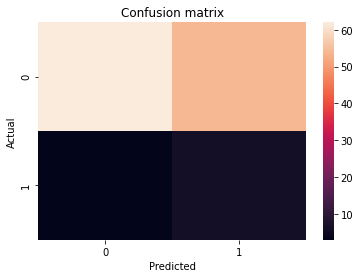

In [23]:

test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")

print()


### Calculating feature importance

In [24]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.401460
2,date,0.054408
3,device_make,0.336032
4,browser,0.208099


Our experiment feature has feature importances of 0. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which with feature importance of 0.45 followed by device_make. But this is a result of a decision tree model with max-depth of 4. if we increase the max-depth, we might observe a differnt result in feature importance.

### Visualzing feature importance

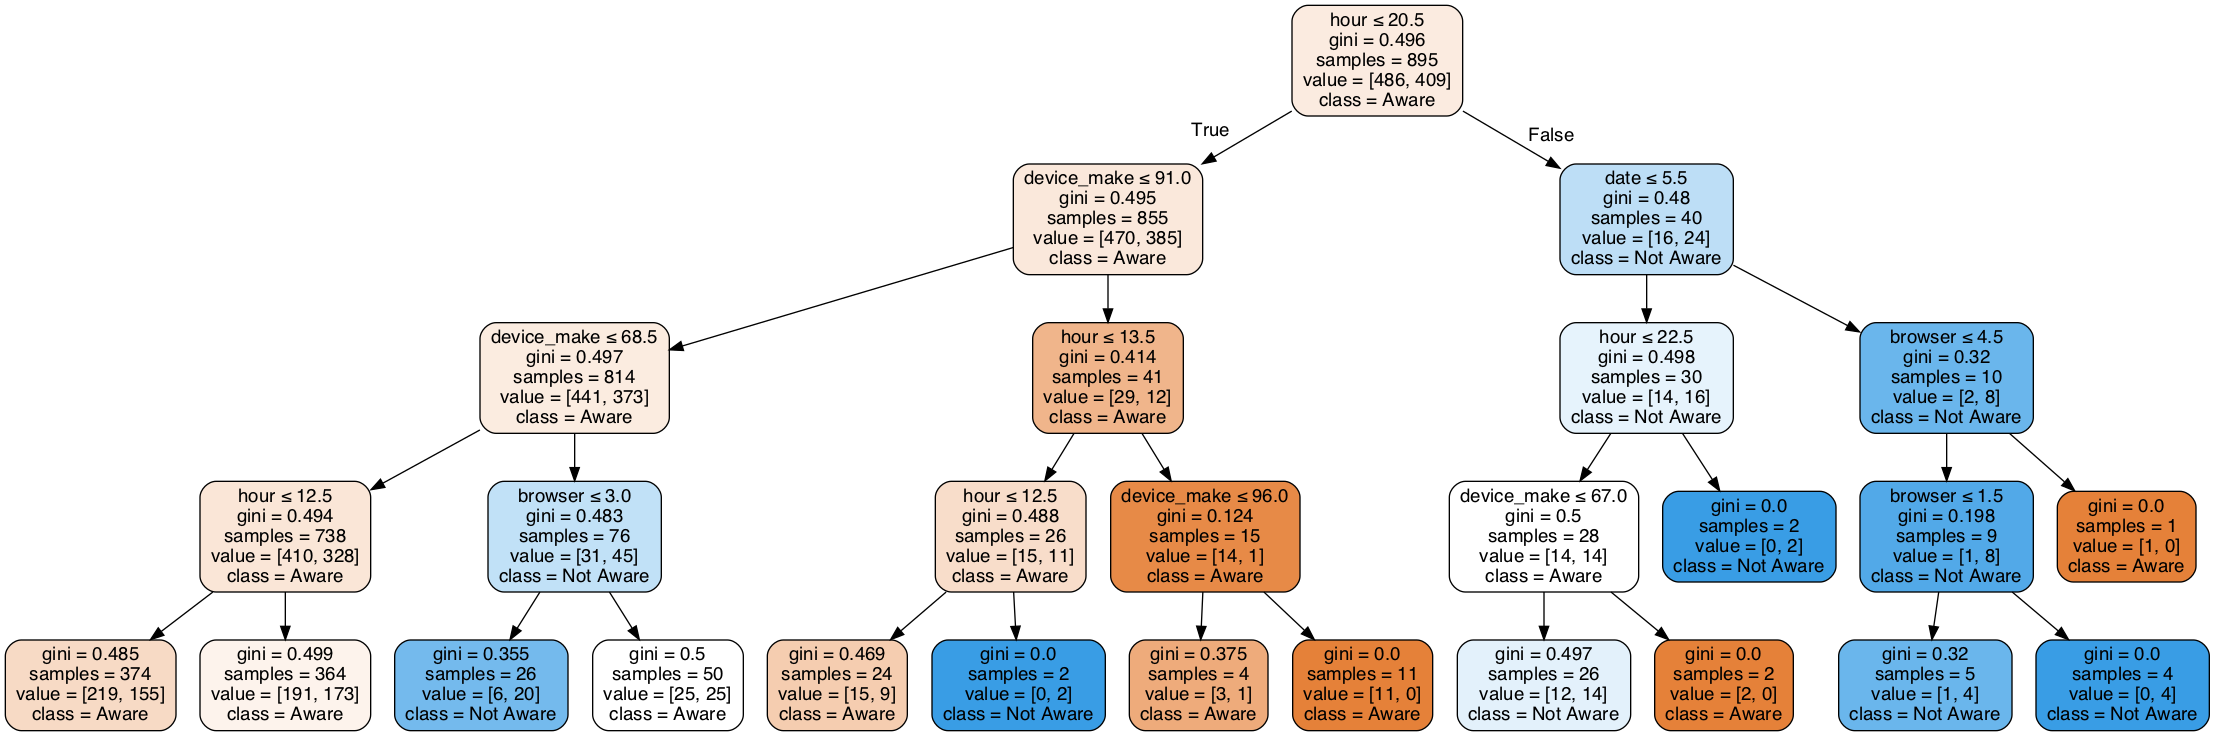

In [25]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())


Our experiment feature is found on the 4th level depth of the Decision Tree. And it only divided leaves with '0' (Not Aware) out come. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which is the root node

### 1.2 Model training using Decision Tree using platform dataframe

In [26]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [27]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

helper.write_model('platform_os_decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.527
step 1: Validation Loss of DecisionTreesModel is: 0.688

step 2: Validation Accuracy of DecisionTreesModel is: 0.554
step 2: Validation Loss of DecisionTreesModel is: 0.668

step 3: Validation Accuracy of DecisionTreesModel is: 0.502
step 3: Validation Loss of DecisionTreesModel is: 0.706

step 4: Validation Accuracy of DecisionTreesModel is: 0.543
step 4: Validation Loss of DecisionTreesModel is: 0.676



step 1: Test Accuracy of DecisionTreesModel is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       113
           1       0.15      0.75      0.25        12

    accuracy                           0.57       125
   macro avg       0.55      0.65      0.47       125
weighted avg       0.88      0.57      0.65       125

Loss on test data is: 0.657



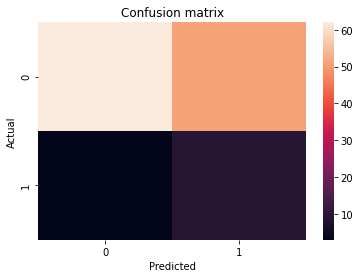

In [28]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [29]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.014389
1,hour,0.453469
2,date,0.176664
3,device_make,0.355477
4,platform_os,0.000000


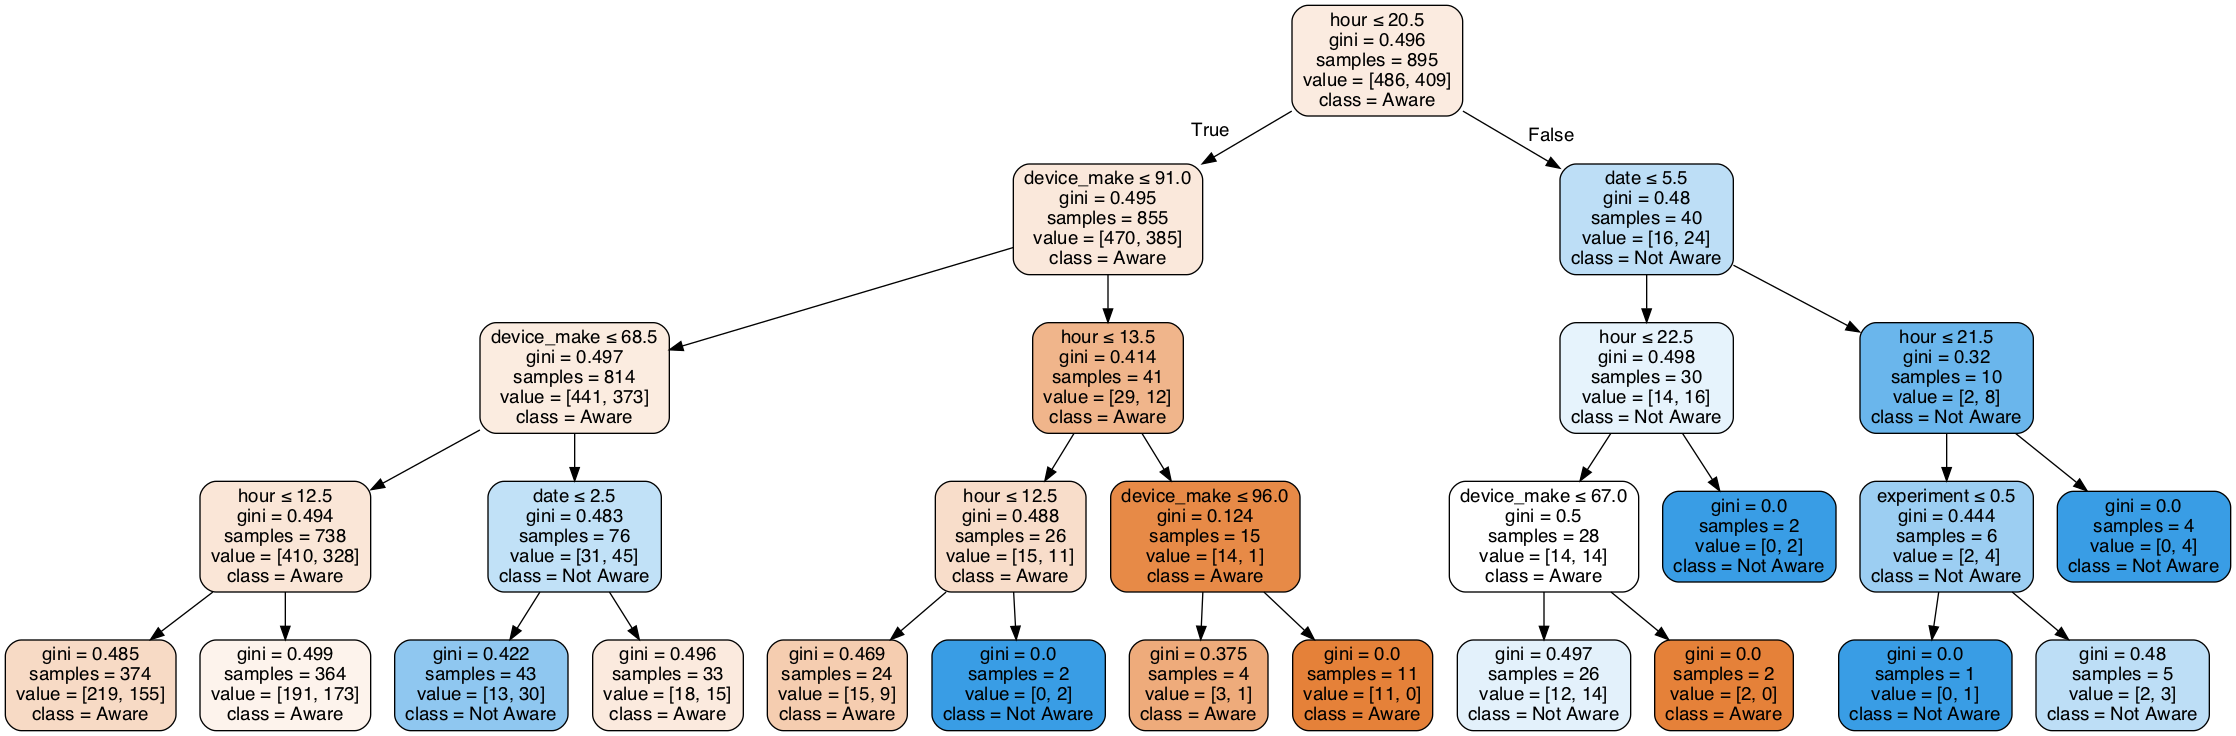

In [30]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())



### Model Building using Logestic Regression

### 2.1 Model training using Logestic Regression using browser dataframe

In [31]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [32]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

helper.write_model('browser_Logestic_Reg_model', clf2)


step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



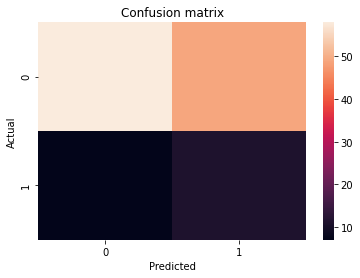

In [33]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

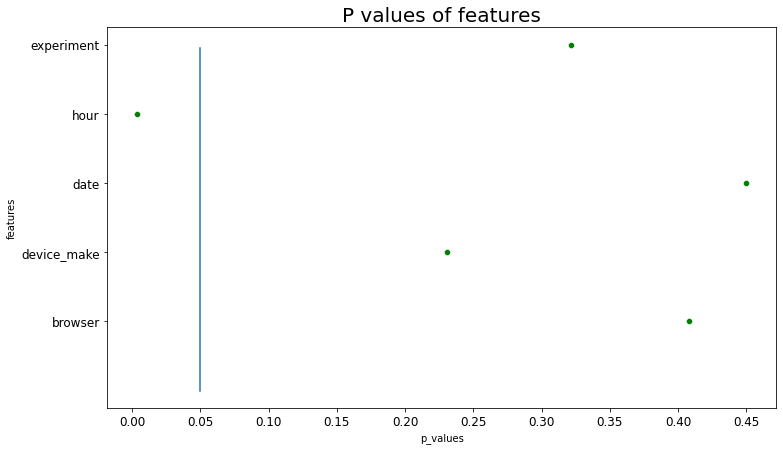

,features,p_values
0,experiment,0.321315
1,hour,0.003776
2,date,0.449766
3,device_make,0.230609
4,browser,0.408101


In [34]:

p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df


The P-value for experiment is 0.3. It is not that much significant, since our significance level is 0.05. Hour is the most important predictor for the Logestic Regression Model with p value 0.001, it is then follwed by device_make then experiment. The least predictor for the Logestic Regression Model is date

### 2.2 Model training using Logestic Regression using platfrom dataframe


In [35]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [36]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

helper.write_model('platform_os_Logestic_Reg_model', clf2)


step 0: Validation Accuracy of LogesticRegression is: 0.518
step 0: Validation Loss of LogesticRegression is: 0.694

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.558
step 2: Validation Loss of LogesticRegression is: 0.665

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.552
step 4: Validation Loss of LogesticRegression is: 0.670



step 1: Test Accuracy of LogesticRegression is: 0.528
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       112
           1       0.12      0.54      0.19        13

    accuracy                           0.53       125
   macro avg       0.51      0.53      0.43       125
weighted avg       0.83      0.53      0.62       125



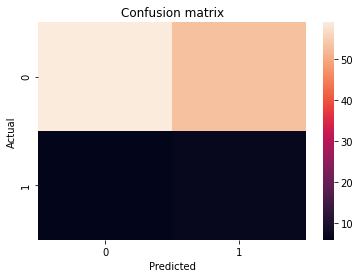

In [37]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

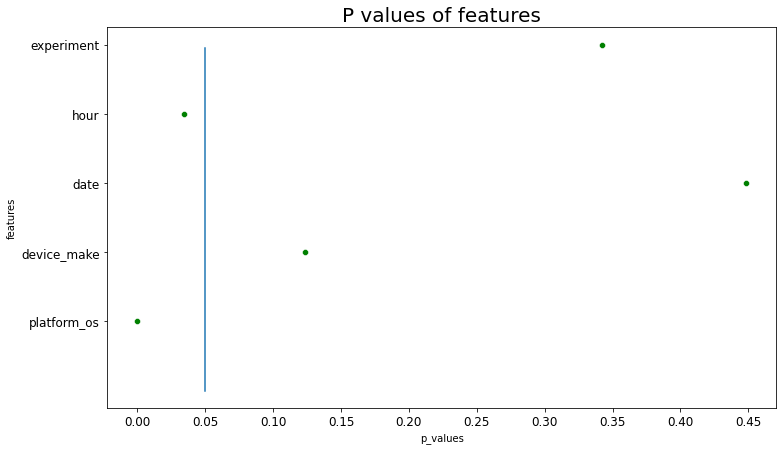

,features,p_values
0,experiment,3.422842e-01
1,hour,3.440592e-02
2,date,4.482927e-01
3,device_make,1.236280e-01
4,platform_os,7.708563e-77


In [38]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

In [39]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [40]:
xGBClassifierModel = XGBClassifierModel(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

helper.write_model('browser_XGBoost_model', clf3)

step 0: Validation Accuracy of DecisionTreesModel is: 0.562
step 0: Validation Loss of DecisionTreesModel is: 0.661

step 1: Validation Accuracy of DecisionTreesModel is: 0.522
step 1: Validation Loss of DecisionTreesModel is: 0.691

step 2: Validation Accuracy of DecisionTreesModel is: 0.545
step 2: Validation Loss of DecisionTreesModel is: 0.675

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.525
step 4: Validation Loss of DecisionTreesModel is: 0.689



step 1: Test Accuracy of DecisionTreesModel is: 0.584
Test Metrics
              precision    recall  f1-score   support

           0       0.78      0.57      0.66        89
           1       0.37      0.61      0.46        36

    accuracy                           0.58       125
   macro avg       0.58      0.59      0.56       125
weighted avg       0.66      0.58      0.60       125

Loss on test data is: 0.645



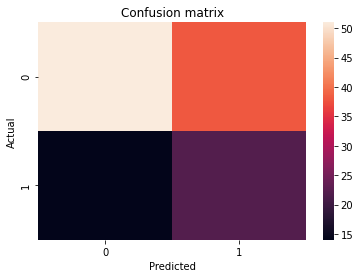

In [41]:
test_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [42]:
xGBClassifierModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.081588
1,hour,0.205326
2,date,0.114857
3,device_make,0.508866
4,browser,0.089362


In [43]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [44]:
xGBClassifierModel = XGBClassifierModel(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

helper.write_model('platforrm_os_XGBoost_model', clf3)

step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.513
step 1: Validation Loss of DecisionTreesModel is: 0.698

step 2: Validation Accuracy of DecisionTreesModel is: 0.536
step 2: Validation Loss of DecisionTreesModel is: 0.681

step 3: Validation Accuracy of DecisionTreesModel is: 0.525
step 3: Validation Loss of DecisionTreesModel is: 0.689

step 4: Validation Accuracy of DecisionTreesModel is: 0.529
step 4: Validation Loss of DecisionTreesModel is: 0.686



step 1: Test Accuracy of DecisionTreesModel is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        87
           1       0.35      0.55      0.43        38

    accuracy                           0.55       125
   macro avg       0.54      0.55      0.53       125
weighted avg       0.62      0.55      0.57       125

Loss on test data is: 0.669



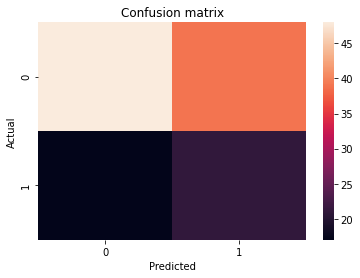

In [45]:
test_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

### Hyper Paramter tuning for Decision Tree

In [47]:

from dt_tune_train import DecisionTree_tune

dt_clf_browser = helper.read_model("../models/browser_decision_tree_model")
dt_clf_platfrom = helper.read_model("../models/platform_os_decision_tree_model")

test_size = 0.1
feature_browser_cols = ["experiment", "hour", "date", 'device_make', 'browser']
browser_X = browser_df[feature_browser_cols]
browser_y = browser_df[['aware']]

feature_platfrom_os_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']
platfrom_X = platform_df[feature_platfrom_os_cols]
platfrom_y = platform_df[['aware']]

dt_browser_df_tuned = DecisionTree_tune(dt_clf_browser, split_train_test(browser_X, browser_y, test_size),
                  loss_function=loss_function,  
                  run_name = 'DT-browser-model-Hyperparameter')

dt_platfrom_df_tuned = DecisionTree_tune(dt_clf_platfrom, split_train_test(platfrom_X, platfrom_y, test_size),
                  loss_function=loss_function,  
                  run_name = 'DT-platfrom-model-Hyperparameter')


2021/07/25 14:52:52 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.
2021/07/25 14:52:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.


### Hyper Paramter tuning for LR

In [48]:
from lr_tune_train import LogisticeRegressionTune



lr_clf_browser = helper.read_model("../models/browser_Logestic_Reg_model")
lr_clf_platfrom = helper.read_model("../models/platform_os_Logestic_Reg_model")

test_size = 0.1
feature_browser_cols = ["experiment", "hour", "date", 'device_make', 'browser']
browser_X = browser_df[feature_browser_cols]
browser_y = browser_df[['aware']]

feature_platfrom_os_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']
platfrom_X = platform_df[feature_platfrom_os_cols]
platfrom_y = platform_df[['aware']]

lr_browser_df_tuned = LogisticeRegressionTune(lr_clf_browser, split_train_test(browser_X, browser_y, test_size),
                loss_function=loss_function,  
                run_name = 'LR-browser-model-Hyperparameter')

lr_platfrom_df_tuned = LogisticeRegressionTune(lr_clf_platfrom, split_train_test(platfrom_X, platfrom_y, test_size),
                loss_function=loss_function,  
                run_name = 'LR-platfrom-model-Hyperparameter')

2021/07/25 14:52:55 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.
2021/07/25 14:52:56 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


### Hyper Paramter tuning for GradientBoost

In [49]:

from xbg_tune_train import XGBoost_tune


xgb_clf_browser = helper.read_model("../models/browser_XGBoost_model")
xgb_clf_platfrom = helper.read_model("../models/platforrm_os_XGBoost_model")

test_size = 0.1
feature_browser_cols = ["experiment", "hour", "date", 'device_make', 'browser']
browser_X = browser_df[feature_browser_cols]
browser_y = browser_df[['aware']]

feature_platfrom_os_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']
platfrom_X = platform_df[feature_platfrom_os_cols]
platfrom_y = platform_df[['aware']]

xgb_browser_df_tuned = XGBoost_tune(xgb_clf_browser, split_train_test(browser_X, browser_y, test_size),
                loss_function=loss_function,  
                run_name = 'xgb-browser-model-Hyperparameter')

xgb_platfrom_df_tuned = XGBoost_tune(xgb_clf_platfrom, split_train_test(platfrom_X, platfrom_y, test_size),
                loss_function=loss_function,  
                run_name = 'xgb-platfrom-model-Hyperparameter')

2021/07/25 14:52:59 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2021/07/25 14:53:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
